

Use Case 2: Data Pipeline for Customer Feedback Analysis          (10 Marks)


Problem Statement:
                        A tech company collects customer feedback data from different channels such as emails, social media, and surveys. The feedback contains structured (ratings) and unstructured (comments) data. Your job is to build a data pipeline to ingest, clean, and analyze this feedback to identify key trends and sentiment.

Sample Data Structure:
Feedback Data File (feedback_data.csv)
Customer ID: (e.g., "C12345", "C67890")
Feedback Channel: (e.g., "Email", "Social Media", "Survey")
Rating (1-5): (e.g., 3, 4, 5)
Comment:
(e.g., "The service was great!", "Could improve product quality.")
Date:
(e.g., "2024-11-01", "2024-11-02")


Tasks for Students:

1.    Data Ingestion: Use tools like Apache Kafka or Apache Spark to ingest data in real time.

2.    Data Cleaning: Process and clean the comments by removing unnecessary characters, correcting misspellings, and handling missing values.

3.    Sentiment Analysis: Perform sentiment analysis on the unstructured text data to classify feedback as positive, neutral, or negative.

4.    Trend Analysis:
                        o   Analyze feedback trends over time.
                        o   Determine which feedback channels generate the most negative or positive comments.
                        o   Calculate average ratings per channel and identify areas for improvement.

5.    Data Visualization: Create visualizations to show sentiment distribution, feedback trends, and channel performance.


 Expected Outcome:
                                Students should create an end-to-end data pipeline that processes feedback data and provides  insights through sentiment analysis and trend visualizations. The final output should be a report with actionable insights for improving customer satisfaction.

Data Pipeline for Customer Feedback Analysis

+----------------+------------------+
|Feedback Channel|    Average_Rating|
+----------------+------------------+
|           Email|2.9646601941747575|
|    Social Media| 3.011077158135982|
|          Survey| 2.950534230312624|
+----------------+------------------+

+----------------+---------+-----+
|Feedback Channel|sentiment|count|
+----------------+---------+-----+
|    Social Media|  neutral|  493|
|           Email| negative| 1087|
|          Survey| positive|  976|
|           Email|  neutral|  468|
|           Email| positive| 1020|
|    Social Media| positive| 1072|
|    Social Media| negative| 1053|
|          Survey|  neutral|  495|
|          Survey| negative| 1056|
+----------------+---------+-----+

+----------------+---------+-----+
|Feedback Channel|sentiment|count|
+----------------+---------+-----+
|    Social Media|  neutral|  493|
|           Email| negative| 1087|
|          Survey| positive|  976|
|           Email|  neutral|  468|
|           Email| positive| 102

<ipython-input-11-f5216fd5a0d1>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_ratings_pd, x="Feedback Channel", y="Average_Rating", palette="viridis")


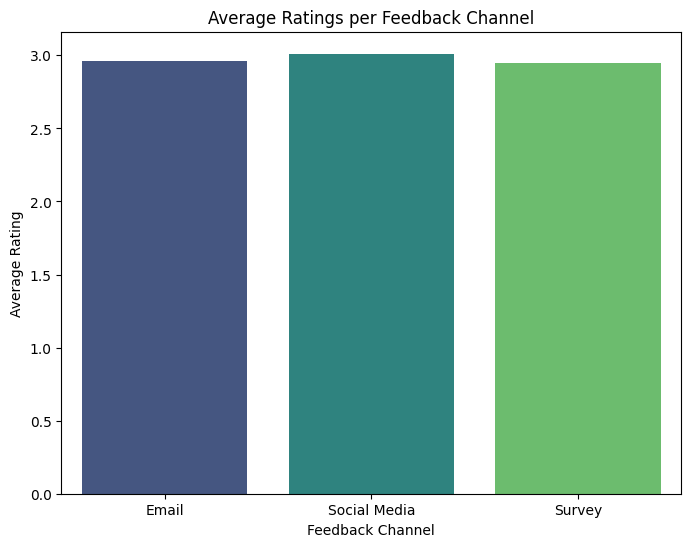

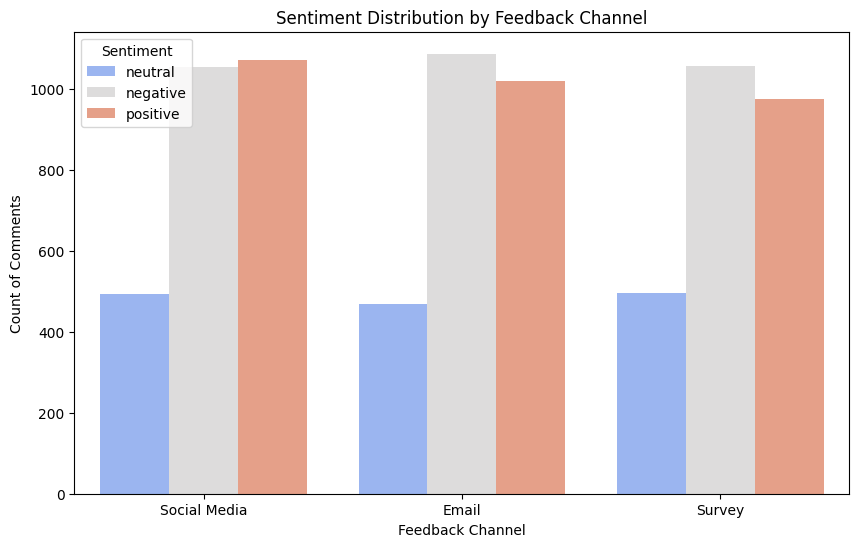

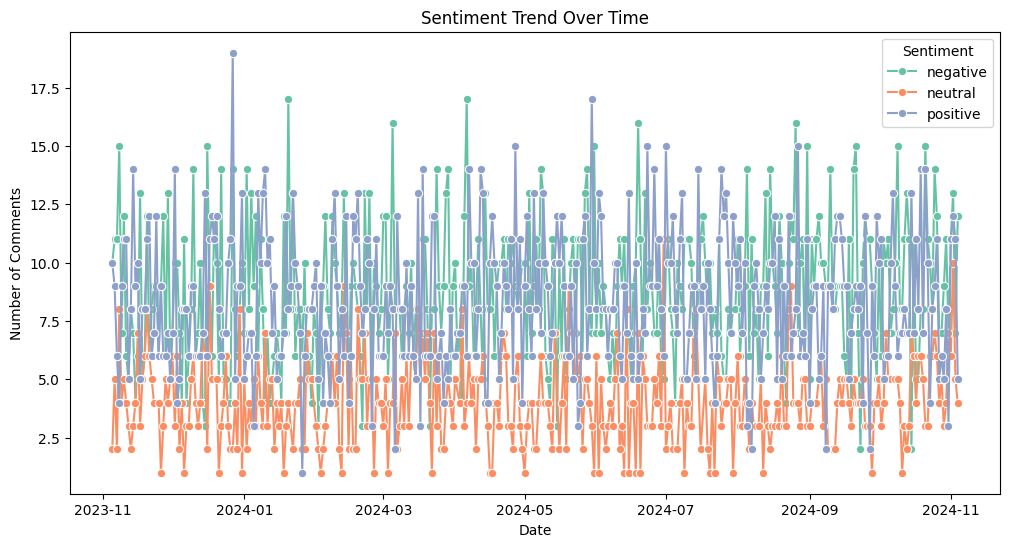

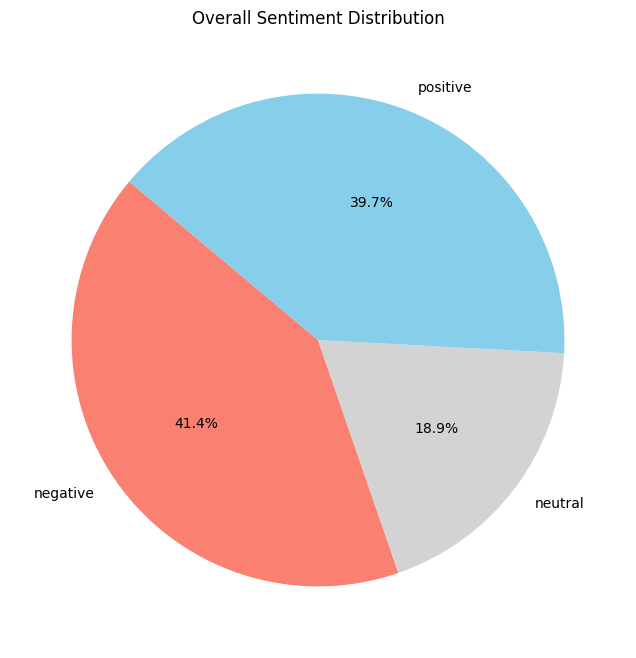

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, when, avg, count, to_date
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline
import pandas as pd

# Initializing the Spark session
spark = SparkSession.builder.appName("CustomerFeedbackAnalysis").getOrCreate()

# Loading the dataset
feedback_df = spark.read.csv("feedback_data.csv", header=True, inferSchema=True)

# 1. Data Cleaning
feedback_df = feedback_df.dropna(subset=["Customer ID", "Feedback Channel", "Rating", "Comment", "Date"])
feedback_df = feedback_df.withColumn("Comment", regexp_replace(col("Comment"), "[^a-zA-Z0-9\s]", ""))
feedback_df = feedback_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# 2. Tokenization and Stopwords Removal
tokenizer = Tokenizer(inputCol="Comment", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")

# 3. Sentiment Analysis (positive if rating > 3, orelse negative/neutral)
feedback_df = feedback_df.withColumn("sentiment",
                                     when(col("Rating").isin(4, 5), "positive")
                                     .when(col("Rating") == 3, "neutral")
                                     .otherwise("negative"))


# 4. Trend Analysis
avg_ratings = feedback_df.groupBy("Feedback Channel").agg(avg("Rating").alias("Average_Rating"))
channel_counts = feedback_df.groupBy("Feedback Channel", "sentiment").count()

# 5. Data Visualization
avg_ratings.show()
channel_counts.show()
feedback_df.groupBy("Feedback Channel", "sentiment").count().show()


import matplotlib.pyplot as plt
import seaborn as sns

# Converting Spark DataFrames to Pandas for Visualization
avg_ratings_pd = avg_ratings.toPandas()
channel_counts_pd = channel_counts.toPandas()

# Visualization 1: Average Ratings per Channel
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_ratings_pd, x="Feedback Channel", y="Average_Rating", palette="viridis")
plt.title("Average Ratings per Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Average Rating")
plt.show()
print(" ")
# Visualization 2: Sentiment Distribution by Feedback Channel
plt.figure(figsize=(10, 6))
sns.barplot(data=channel_counts_pd, x="Feedback Channel", y="count", hue="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution by Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Count of Comments")
plt.legend(title="Sentiment")
plt.show()
print(" ")

# Aggregations
# Grouping data by date and sentiment for trend analysis
trend_data = feedback_df.groupBy("Date", "sentiment").count().orderBy("Date")
trend_data_pd = trend_data.toPandas()
trend_data_pd["Date"] = pd.to_datetime(trend_data_pd["Date"])

# Visualization 3: Sentiment Trend Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data_pd, x="Date", y="count", hue="sentiment", marker="o", palette="Set2")
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.legend(title="Sentiment")
plt.show()
print(" ")

# Calculate overall sentiment counts
overall_sentiment_counts = channel_counts_pd.groupby("sentiment")["count"].sum()

# Pie Chart for Sentiment Distribution
plt.figure(figsize=(8, 8))
plt.pie(overall_sentiment_counts, labels=overall_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=["salmon", "lightgray", "skyblue"])
plt.title("Overall Sentiment Distribution")
plt.show()


# Stopping the Spark session
spark.stop()
